# Libraries and Data Load

In [177]:
#%pip install torchinfo

In [178]:
#pip install skorch

In [179]:
#pip install transformers

In [167]:
# - torch is the main PyTorch library.
# - torchvision is used for accessing pre-trained models and datasets and contains transformations for images.
# - matplotlib.pyplot is a plotting library used for creating static, animated, and interactive visualizations in Python.
# - Image from PIL (Python Imaging Library) is used for opening, manipulating, and saving many different image file formats.
# - os module provides a way of using operating system-dependent functionality.
# - pandas is a fast, powerful, and easy-to-use open-source data analysis and data structure manipulation library.
# - numpy is a library used for working with arrays and matrices of numeric data, along with mathematical operations.
# - nn from torch is used for building neural networks.
# - summary from torchinfo provides a detailed layer-by-layer description of PyTorch models.
# - GridSearchCV from sklearn.model_selection is used for performing grid search with cross-validation to tune hyperparameters.
# - NeuralNetClassifier from skorch is a scikit-learn compatible neural network library that wraps PyTorch.
# - AutoTokenizer from transformers is used for loading the tokenizer corresponding to the pre-trained models.
# - cv2 (OpenCV) is a library of programming functions mainly aimed at real-time computer vision.

import torch
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import numpy as np
import torch.nn as nn
from torchinfo import summary
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
from transformers import AutoTokenizer
import cv2 as cv

In [128]:
folder_path = '/Users/alaa/Downloads/final_project/KHAAT_HF/Training'
folder_path2 = '/Users/alaa/Downloads/final_project/KHAAT_HF/Validation'

all_files = os.listdir(folder_path)
val_files = os.listdir(folder_path2)

In [129]:
image_files = [f for f in all_files if f.endswith('.tif')]
label_files = [f for f in all_files if f.endswith('.txt')]

In [130]:
image_files_val = [f for f in val_files if f.endswith('.tif')]
label_files_val = [f for f in val_files if f.endswith('.txt')]

In [131]:
import pandas as pd

df = pd.DataFrame({
    'image_file': [os.path.join(folder_path, img) for img in image_files],
    'label_file': [os.path.join(folder_path, lbl) for lbl in label_files]
})

# Sort DataFrame to make sure image and label files align correctly
df = df.sort_values(by=['image_file', 'label_file']).reset_index(drop=True)


In [132]:
import pandas as pd

df_val = pd.DataFrame({
    'image_file': [os.path.join(folder_path, img) for img in image_files_val],
    'label_file': [os.path.join(folder_path, lbl) for lbl in label_files_val]
})

# Sort DataFrame to make sure image and label files align correctly
df_val = df.sort_values(by=['image_file', 'label_file']).reset_index(drop=True)


In [133]:
df.head()

,image_file,label_file
0,/Users/alaa/Downloads/final_project/KHAAT_HF/T...,/Users/alaa/Downloads/final_project/KHAAT_HF/T...
1,/Users/alaa/Downloads/final_project/KHAAT_HF/T...,/Users/alaa/Downloads/final_project/KHAAT_HF/T...
2,/Users/alaa/Downloads/final_project/KHAAT_HF/T...,/Users/alaa/Downloads/final_project/KHAAT_HF/T...
3,/Users/alaa/Downloads/final_project/KHAAT_HF/T...,/Users/alaa/Downloads/final_project/KHAAT_HF/T...
4,/Users/alaa/Downloads/final_project/KHAAT_HF/T...,/Users/alaa/Downloads/final_project/KHAAT_HF/T...


# ResNet 50

In [134]:
from torchvision.models import resnet50

resnet50 = models.resnet50(weights = True)

/Users/alaa/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# DataLoader

In [135]:
from skimage.filters import butterworth
from skimage.filters import gaussian
from skimage import exposure



In [136]:
from transformers import AutoTokenizer
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
import torch

class ImageToTextDataset(Dataset):
    def __init__(self, image_paths, text_labels, transform=None):
        self.image_paths = image_paths
        self.text_labels = text_labels
        self.tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        text_label = self.text_labels[idx]
        
        # Load and transform image
        image = Image.open(image_path)
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        # Tokenize text_label, then convert to tensor
        tokenized_text = self.tokenizer(
            text_label, 
            padding='max_length', 
            truncation=True, 
            max_length=50, 
            return_tensors="pt"
        )
        
        return image, tokenized_text["input_ids"].squeeze(), tokenized_text["attention_mask"].squeeze()




In [175]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
vocab_size = len(tokenizer.get_vocab())

print("Number of tokens in the tokenizer:", vocab_size)


Number of tokens in the tokenizer: 64000


In [180]:
# # Perform Inference to get generated text
# image_path = '/Users/alaa/Downloads/final_project/KHAAT_HF/Training/AHTD3A0001_Para2_4.tif'  # Replace with your image path
# generated_text = image_to_text_inference(image_path, model, val_transform, tokenizer, start_token_id, end_token_id)

# # Tokenize the generated text
# tokens = tokenizer.tokenize(generated_text)

# # Calculate and print the number of tokens
# number_of_tokens = len(tokens)
# print("Number of tokens in the generated text:", number_of_tokens)


In [137]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2

batchsize = 8
transform = transforms.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

val_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

Mura_transform = ImageToTextDataset(df["image_file"], df["label_file"], transform=transform)
train_loader = DataLoader(Mura_transform, batch_size=batchsize, shuffle=True)
Mura_transform_valid = ImageToTextDataset(df_val["image_file"], df_val["label_file"], transform=val_transform)
valid_loader = DataLoader(Mura_transform_valid, batch_size=batchsize)

/Users/alaa/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [163]:
# def directionalHistogram(img, direction='H'):
#   #function to compute the intensity histograms of an image in x and y directions
#     (w,h) = img.shape
#     sum = []
#     pixel_count=0
#     if(direction=='H'):
#         for j in range(w-1):
#           for i in range(h-1):
#             pixel=img[j,i]
#             if(pixel==255):
#               pixel_count+=1
#           sum.append(pixel_count)
#           pixel_count=0
#     else:
#        for j in range(h-1):
#           for i in range(w-1):
#             pixel=img[i,j]
#             if(pixel==255):
#               pixel_count+=1
#           sum.append(pixel_count)
#           pixel_count=0
#     return sum

# def crop_image(image, direction='H'):
#   #function to crop the image in vertical and horizontal directions
#   w,h=image.shape
#   if(w<10 or h<10):
#     return image

#   hist=directionalHistogram(image, direction )
#   flipped_hist=np.flip(hist)
#   startpos=0
#   endpos=0
#   for i in range(1, len(hist)-1):
#     if(hist[i-1]==0 and hist[i]==0 and hist[i+1]!=0):
#       startpos=i
#       break
#   for i in range(1, len(flipped_hist)-1):
#     if(hist[i-1]==0 and hist[i]==0 and hist[i+1]!=0):
#       endpos=len(flipped_hist)-1-i
#       break

#   diff=np.abs(startpos-endpos)
#   if(direction=='H' and diff>=10 and startpos<endpos):
#     if(startpos<endpos):
#       return image[startpos:endpos,:]
#     else:
#       return image[endpos:startpos,:]
#   elif(direction=='V' and diff>=10 and startpos<endpos):
#     if(startpos<endpos):
#       return image[:,startpos:endpos]
#     else:
#       return image[:,endpos:startpos]
#   else:
#     return image

# image_width = 64
# image_height = 32
# def distortion_free_resize(image, img_size=(image_height, image_width)):
#   #resizing the images without distortion using tensorflow
#     h,w= img_size
#     image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

#     # Check tha amount of padding needed to be done.
#     pad_height = h - tf.shape(image)[0]
#     pad_width = w - tf.shape(image)[1]

#     # Only necessary if you want to do same amount of padding on both sides.
#     if pad_height % 2 != 0:
#         height = pad_height // 2
#         pad_height_top = height + 1
#         pad_height_bottom = height
#     else:
#         pad_height_top = pad_height_bottom = pad_height // 2

#     if pad_width % 2 != 0:
#         width = pad_width // 2
#         pad_width_left = width + 1
#         pad_width_right = width
#     else:
#         pad_width_left = pad_width_right = pad_width // 2

#     image = tf.pad(
#         image,
#         paddings=[
#             [pad_height_top, pad_height_bottom],
#             [pad_width_left, pad_width_right],
#             [0, 0],
#         ],
#     )

#     image = tf.transpose(image, perm=[1, 0, 2])
#     image = tf.image.flip_left_right(image)
#     return image

In [165]:
# #list the filenames in the folder containing your dataset
# filenames=os.listdir('/Users/alaa/Downloads/huge_kKHAAT_dataset/Wr_ID_Training')
# #strip the file extension from the file names
# filenames_split=[filename.replace('.tif', '') for filename in filenames]

In [181]:
# for m in range(len(filenames)):
#   # read the image in grey scale
#   image = cv.imread('/Users/alaa/Downloads/huge_kKHAAT_dataset/Wr_ID_Training'+filenames[m],0)
#   # skeletonize the image
#   #image=cv.ximgproc.thinning(image)
#   #crop the image horizontally
#   image_v_cropped=crop_image(image, 'V')
#   #convert image to RGB
#   image_v_cropped=cv.cvtColor(image_v_cropped,cv.COLOR_GRAY2RGB)
#   #distortionless resize with tensorflow
#   image=distortion_free_resize(image_v_cropped)
#   #convert image back to np array as grey scale and save it as jpg
#   image=cv.cvtColor(image.numpy(),cv.COLOR_RGB2GRAY)
#   image=np.rot90(image)
#   cv.imwrite("//Users/alaa/Downloads/huge_kKHAAT_dataset/processed_images/"+filenames_split[m]+".tif", image)

# Preprossessing

In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2

batchsize = 8
transform = transforms.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

val_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

Mura_transform = ImageToTextDataset(df["image_file"], df["label_file"], transform=transform)
train_loader = DataLoader(Mura_transform, batch_size=batchsize, shuffle=True)
Mura_transform_valid = ImageToTextDataset(df_val["image_file"], df_val["label_file"], transform=val_transform)
valid_loader = DataLoader(Mura_transform_valid, batch_size=batchsize)



Feature batch shape: torch.Size([8, 3, 224, 224])
Input IDs batch shape: torch.Size([8, 50])
Attention Mask batch shape: torch.Size([8, 50])


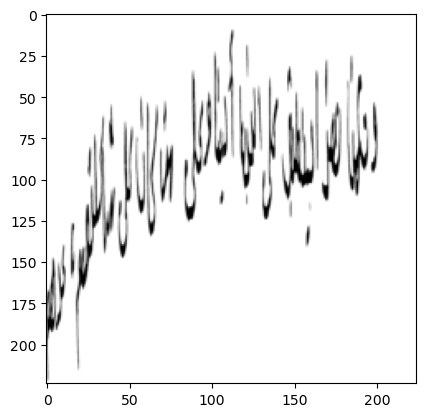

First set of input IDs: tensor([    2,     1,    58, 34772,   203,   223,     1, 34026,   177,   177,
            1,    41, 21419,   179,   220,   219, 16195,   223,     1,    75,
         5037,  6403,    68, 48552,   226, 45942,     1,    48,   261,   248,
        39096,    68,    45,   244,     1,    57,  7957,  5037, 11388,     1,
           38,   261,   242,   262,   227,   248,   188, 12276,   191,     3])
First set of attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])


In [138]:
# Unpack data
train_features, input_ids, attention_mask = next(iter(train_loader))

# Display features and labels shapes
print(f"Feature batch shape: {train_features.size()}")
print(f"Input IDs batch shape: {input_ids.size()}")
print(f"Attention Mask batch shape: {attention_mask.size()}")

# Select a single image from the batch
img = train_features[0]

# Display a channel of the image (for example, the first channel)
img_channel1 = img[0].cpu().numpy()  # Changed the channel index to 0, assuming the first channel is what you want
plt.imshow(img_channel1, cmap="gray")
plt.show()

# Inspect the first set of input IDs and attention mask
print(f"First set of input IDs: {input_ids[0]}")
print(f"First set of attention mask: {attention_mask[0]}")


In [139]:
print(captions.min(), captions.max())


tensor(1) tensor(48552)


In [140]:
summary(resnet50, input_size=(8, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [8, 1000]                 --
├─Conv2d: 1-1                            [8, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]         128
├─ReLU: 1-3                              [8, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [8, 64, 56, 56]           --
├─Sequential: 1-5                        [8, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [8, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [8, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [8, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [8, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [8, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [8, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [8, 64, 56, 56]           --
│ 

In [141]:
# Initialize the CrossEntropyLoss.
# It’s used as a loss function for classification problems.
# In this case, it’s used to calculate the difference between the generated text and the target text.
criterion = torch.nn.CrossEntropyLoss()

# Initialize the Adam optimizer.
# Adam is an optimization algorithm used to minimize the loss function during training.
# It’s passed the parameters of the resnet50 model and a learning rate of 1e-5.
# Learning Rate (lr) determines the step size at each iteration while moving towards a minimum of the loss function.
# The smaller the learning rate, the slower we travel along the downward slope.
optimizer = torch.optim.Adam(resnet50.parameters(), lr=1e-5)

# Initialize the Learning Rate Scheduler.
# It’s used to adjust the learning rate during training, which can lead to faster convergence and better performance.
# StepLR decreases the learning rate by gamma (0.7) every 10 epochs, making the optimizer take smaller steps.
# It’s helpful in controlling the learning process, especially in the later stages of training.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)


In [142]:
# num_ftrs = resnet50.fc.in_features 
# resnet50.fc = torch.nn.Linear(num_ftrs, 2)  

In [143]:
# Print a summary of the resnet50 model showing layer-wise information and parameter counts,
# assuming a batch of 8 images, each of size 3x224x224 as input.
#8: Number of images per batch (Batch Size).3: Number of color channels in the image (usually RGB).
#224: Height of the input images.224: Width of the input images.
summary(resnet50, input_size=(8, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [8, 1000]                 --
├─Conv2d: 1-1                            [8, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]         128
├─ReLU: 1-3                              [8, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [8, 64, 56, 56]           --
├─Sequential: 1-5                        [8, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [8, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [8, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [8, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [8, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [8, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [8, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [8, 64, 56, 56]           --
│ 

# Modeling

In [150]:
# import torch
# import torch.nn as nn
# from torchvision.models import resnet50

# class ImageToTextModel(nn.Module):
#     def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
#         super(ImageToTextModel, self).__init__()
        
#         # Use a pre-trained ResNet model for feature extraction
#         self.resnet = resnet50(pretrained=True)
        
#         # Remove the classification head (last layer)
#         modules = list(self.resnet.children())[:-2]
#         self.resnet = nn.Sequential(*modules)
        
#         # Use a fully connected layer to reduce dimensions
#         self.fc = nn.Linear(2048, embed_size)
        
#         # RNN for sequence generation
#         self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
#         # Fully connected layer to match the LSTM output to vocabulary size
#         self.linear = nn.Linear(hidden_size, vocab_size)
        
#         # Embedding layer
#         self.embed = nn.Embedding(vocab_size, embed_size)
        
#     def forward(self, images, captions):
#         # Forward pass through ResNet
#         features = self.resnet(images)
        
#         # Average pooling
#         features = features.mean(-1).mean(-1)
        
#         # Dimensionality reduction
#         features = self.fc(features)
        
#         # Forward pass through LSTM
#         embeddings = self.embed(captions)
#         features = features.unsqueeze(1)
#         inputs = torch.cat((features, embeddings), 1)
#         hiddens, _ = self.rnn(inputs)
        
#         # Forward pass through Linear layer
#         outputs = self.linear(hiddens)
        
#         return outputs


In [170]:
# The ImageToTextModel is designed to convert input images to sequences of text tokens.
# It uses a pre-trained ResNet-50 model to extract feature representations from input images.
# These features are then passed through a sequence generation module consisting of LSTM cells
# to generate sequences of token IDs, which can be converted back to text using a tokenizer.
# The model additionally uses dropout and batch normalization for regularization, and an embedding layer
# to convert token IDs to fixed-size vectors. It is suitable for tasks like Image Captioning where the
# goal is to generate descriptive text for images.

import torch
import torch.nn as nn
from torchvision.models import resnet50

class ImageToTextModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_p=0.5):
        super(ImageToTextModel, self).__init__()
        
        # Use a pre-trained ResNet model for feature extraction
        self.resnet = resnet50(pretrained=True)
        
        # Remove the classification head (last layer)
        modules = list(self.resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Use a fully connected layer to reduce dimensions
        self.fc = nn.Linear(2048, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)  # Batch Normalization
        self.dropout = nn.Dropout(dropout_p)  # Dropout
        
        # RNN for sequence generation
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout_p if num_layers > 1 else 0)
        
        # Fully connected layer to match the LSTM output to vocabulary size
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        # Embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, images, captions):
        # Forward pass through ResNet
        features = self.resnet(images)
        
        # Average pooling
        features = features.mean(-1).mean(-1)
        
        # Dimensionality reduction
        features = self.dropout(self.bn(self.fc(features)))
        
        # Forward pass through LSTM
        embeddings = self.embed(captions)
        features = features.unsqueeze(1)
        inputs = torch.cat((features, embeddings), 1)
        hiddens, _ = self.rnn(inputs)
        
        # Forward pass through Linear layer
        outputs = self.linear(hiddens)
        
        return outputs

# Example instantiation (you can adjust dropout_p as needed)
model = ImageToTextModel(vocab_size, embed_size, hidden_size, num_layers, dropout_p=0.5)


In [182]:
# This code initializes the ImageToTextModel, criterion, and optimizer and then trains
# the model for a specified number of epochs. It is using a CrossEntropyLoss as the criterion.
# During training, for each batch of images and corresponding captions from the train_loader,
# it performs a forward pass to compute the output predictions of the model, calculates the loss,
# performs backpropagation to compute the gradients, and then updates the model’s parameters.
# It will print the training loss at every 100 steps.


import torch
import torch.optim as optim
import torch.nn.functional as F

# Initialize the model, loss, and optimizer
vocab_size = 48559  # replace with the size of your vocabulary
embed_size = 256
hidden_size = 512
num_layers = 22


model = ImageToTextModel(vocab_size, embed_size, hidden_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, captions, _) in enumerate(train_loader):  # we ignore attention masks for simplicity
        
        # Move data to the appropriate device
        images = images
        captions = captions
        
        # Forward pass
        outputs = model(images, captions[:, :-1])  # ignore <END> token for each caption
        outputs = outputs[:, :-1, :]

        targets = captions[:, 1:]  # ignore <START> token for each caption
#         print("Outputs shape:", outputs.shape)
#         print("Targets shape:", targets.shape)

        # Compute loss
        loss = criterion(
            outputs.reshape(-1, vocab_size),  # reshape to 2D tensor
            targets.reshape(-1)  # reshape to 1D tensor
        )
        
        # Zero gradients, perform backpropagation, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print log info
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


Epoch [1/10], Step [1/175], Loss: 10.7974
Epoch [1/10], Step [101/175], Loss: 3.0632
Epoch [2/10], Step [1/175], Loss: 2.6774
Epoch [2/10], Step [101/175], Loss: 2.3718
Epoch [3/10], Step [1/175], Loss: 2.1982
Epoch [3/10], Step [101/175], Loss: 2.0098
Epoch [4/10], Step [1/175], Loss: 1.8266
Epoch [4/10], Step [101/175], Loss: 1.7879
Epoch [5/10], Step [1/175], Loss: 1.6067
Epoch [5/10], Step [101/175], Loss: 1.4784
Epoch [6/10], Step [1/175], Loss: 1.3708
Epoch [6/10], Step [101/175], Loss: 1.2752
Epoch [7/10], Step [1/175], Loss: 1.2031
Epoch [7/10], Step [101/175], Loss: 1.1599
Epoch [8/10], Step [1/175], Loss: 1.0891
Epoch [8/10], Step [101/175], Loss: 1.0017
Epoch [9/10], Step [1/175], Loss: 1.0006
Epoch [9/10], Step [101/175], Loss: 0.9069
Epoch [10/10], Step [1/175], Loss: 0.8668
Epoch [10/10], Step [101/175], Loss: 0.8095


In [187]:
# the average loss, BLEU score, and perplexity of the model.
# - The model is switched to evaluation mode, which means that it won't update
#   the weights while going through the validation data.
# - torch.no_grad() is used as we do not need to compute gradients during validation.
# - The validation loss is accumulated across batches to later calculate the average loss.
# - For each prediction, the BLEU score is calculated between the predicted sequence 
#   and the target sequence, then accumulated to compute the average BLEU score.
# - The average loss is used to calculate the perplexity of the model, a metric 
#   indicating how well the probability distribution predicted by the model aligns 
#   with the true distribution of the data.
# - Finally, the average validation loss, BLEU score, and perplexity are printed out.

from nltk.translate.bleu_score import sentence_bleu
import math

# Initialize the model and optimizer here if not already done
# ...

# Initialize variables
total_val_loss = 0.0
total_examples = 0
total_bleu_score = 0.0  # Added for BLEU Score

# Make sure to move your model to evaluation mode
model.eval()

# No need to keep track of gradients during validation, so we use torch.no_grad()
with torch.no_grad():
    for i, (images, captions, _) in enumerate(valid_loader):  # replace val_loader with your validation loader
        # Move data to the appropriate device
        images = images
        captions = captions
        
        # Forward pass
        outputs = model(images, captions[:, :-1])  # ignore <END> token for each caption
        outputs = outputs[:, :-1, :]  # truncate the extra timestep
        targets = captions[:, 1:]  # ignore <START> token for each caption

        # Compute loss
        loss = criterion(
            outputs.reshape(-1, vocab_size),  # reshape to 2D tensor
            targets.reshape(-1)  # reshape to 1D tensor
        )

        # Accumulate validation loss
        total_val_loss += loss.item() * images.size(0)  # loss multiplied by batch size
        total_examples += images.size(0)

        # Compute BLEU Score
        predicted_tokens = torch.argmax(outputs, dim=2)
        for target, predicted in zip(targets, predicted_tokens):
            target_text = tokenizer.decode(target.cpu().numpy())
            predicted_text = tokenizer.decode(predicted.cpu().numpy())

            bleu_score = sentence_bleu([target_text.split()], predicted_text.split())
            total_bleu_score += bleu_score  # Accumulate BLEU Score

        # Print log info
        if i % 100 == 0:
            print(f"Validation Step [{i+1}/{len(valid_loader)}], Loss: {loss.item():.4f}")

# Compute the average validation loss over all validation samples
average_val_loss = total_val_loss / total_examples
average_bleu_score = total_bleu_score / total_examples  # Compute average BLEU Score

# Compute Perplexity based on the average validation loss
perplexity = math.exp(average_val_loss)

# Print metrics
print(f"Average Validation Loss: {average_val_loss:.4f}")
print(f"Average Validation BLEU Score: {average_bleu_score:.4f}")
print(f"Validation Perplexity: {perplexity:.4f}")

Validation Step [1/175], Loss: 0.7500
Validation Step [101/175], Loss: 0.7634
Average Validation Loss: 0.7353
Average Validation BLEU Score: 0.8055
Validation Perplexity: 2.0862


In [183]:
# This function, image_to_text_inference, performs inference on a single image 
# and generates a sequence of text tokens describing it. 
# - The model is put into evaluation mode, which means it won't update its weights.
# - An image is loaded, converted to RGB, and transformed appropriately before being
#   fed to the model.
# - The function generates a sequence of token IDs, starting with a start_token_id 
#   and continuing until it generates an end_token_id or reaches a maximum length. 
#   It does this by feeding the model one token at a time and sampling the next token 
#   from the distribution of output token probabilities, scaled by a temperature parameter.
#   A higher temperature will result in more randomness, while a lower one will make the
#   model more confident in its top choice.
# - The generated sequence of token IDs is then decoded back into text using the tokenizer.
# - The generated text is returned.
# Example usage is also provided, which loads a tokenizer, sets start and end token IDs,
# applies the function to a specific image, and prints out the generated text.

import torch.nn.functional as F

def image_to_text_inference(image_path, model, transform, tokenizer, start_token_id, end_token_id, max_length=50, temperature=1.0):
    model.eval()

    image = Image.open(image_path)
    image = image.convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)

    generated_ids = []
    current_token_id = start_token_id

    with torch.no_grad():
        for _ in range(max_length):
            output = model(image, torch.tensor([[current_token_id]]))
            
            # Apply temperature
            probabilities = F.softmax(output[0, -1, :] / temperature, dim=0)
            
            # Sample from the probabilities
            current_token_id = torch.multinomial(probabilities, 1).item()
            
            generated_ids.append(current_token_id)

            if current_token_id == end_token_id:
                break

    decoded_text = tokenizer.decode(generated_ids)
    
#     for token_id in generated_ids:
#         print(token_id, tokenizer.decode([token_id]))

    return decoded_text

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")

# Define start and end token IDs (you'll need to determine what these are for your specific tokenizer)
start_token_id = tokenizer.cls_token_id  # Typically the token ID for something like "[CLS]" or "<START>"
end_token_id = tokenizer.sep_token_id  # Typically the token ID for something like "[SEP]" or "<END>"

# Perform inference
image_path = '/Users/alaa/Downloads/final_project/KHAAT_HF/Training/AHTD3A0001_Para2_4.tif'
result = image_to_text_inference(image_path, model, val_transform, tokenizer, start_token_id, end_token_id)
print("Generated Text:", result)


Generated Text: U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U U


In [189]:
# print(tokenizer.special_tokens_map)

In [188]:
# # Print a subset of the tokenizer's vocabulary
# vocab_items = list(tokenizer.get_vocab().items())
# for i in range(100):  # print the first 100 items; you can adjust this number
#     print(vocab_items[i])


In [184]:
# # Check the token corresponding to ID 58
# token = tokenizer.decode([58])
# print(f"Token to remove: {token}")

# # Remove the token
# tokenizer.get_vocab().pop(token, None)

# # Verify removal
# if token not in tokenizer.get_vocab():
#     print(f"Token {token} has been removed!")
# else:
#     print(f"Token {token} is still in the vocabulary.")


In [185]:
# import re

# # Regular expression pattern to match English letters
# pattern = re.compile(r'[a-zA-Z]')

# # Find tokens with English letters
# tokens_to_remove = [token for token, idx in tokenizer.get_vocab().items() if pattern.search(token)]

# # Remove those tokens
# for token in tokens_to_remove:
#     tokenizer.get_vocab().pop(token, None)

# # Verify removal by checking a few
# for token in tokens_to_remove[:10]:  # just checking the first 10 for demonstration
#     if token not in tokenizer.get_vocab():
#         print(f"Token {token} has been removed!")
#     else:
#         print(f"Token {token} is still in the vocabulary.")


In [186]:
# token_id = 58
# token = tokenizer.decode([token_id])
# print(token)


In [190]:
#This saves the model 
import torch
save_path = './RESNET_khaat_10epoch.pth'
torch.save(resnet50,save_path)